In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [17]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [21]:
tree_names_nohits = [
    #"RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2Kee_tree_presel.root:DecayTree;180",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [22]:
tree_names_hits = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [23]:
basedir = os.path.expanduser("~/2022/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names_nohits, channel_names)]

In [24]:
files[3].aliases = {
    'B_FD': "D_FD",
    'B_FD_TRUE': "D_FD_TRUE",
}

In [25]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [87]:
class SelectedData(object):
    def __init__(self, datafile, selector, name=None):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
        self.name = self.datafile.name if name is None else name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [103]:
def split(selected, **options):
    selector = selected.index
    name = selected.name
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector, name)
    test = SelectedData(selected.datafile, test_selector, name)
    return train, test

In [104]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2, true=True):
    feature = "q2_TRUE" if true else "q2"
    return join_and("%s > %g" % (feature, v1), "%s < %g" % (feature, v2))

In [105]:
def e_selectors(true=True):
    #q_Kll_selector = q2_range(1.1, 6.0, true)
    q_Jpsi_e_selector = q2_range(6.0, 12.96, true)
    q_psi2S_e_selector = q2_range(9.82, 16.40, true)
    selectors = [
        #q_Kll_selector,
        q_Jpsi_e_selector,
        q_psi2S_e_selector,
        "True",
    ]
    return selectors

#q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [120]:
KEE_BANDS = [0.5, 1.0, 1.5, 2.0, 2.5, 3.5]

In [121]:
def kee_selectors(qs=KEE_BANDS, qw=0.25, true=True):
    selectors = [q2_range((q-qw)**2, (q+qw)**2, true=true) for q in qs]
    return selectors

In [122]:
selectors_true = kee_selectors(true=True) + e_selectors(true=True)
selectors_notrue = kee_selectors(true=False) + e_selectors(true=False)

In [123]:
all_files = [files[0]]*(len(KEE_BANDS)) + files[1:]
all_channel_names = ["%s[%g]"%(channel_names[0], q) for q in KEE_BANDS] + channel_names[1:]

In [124]:
selected_true = [SelectedData(f, f.get([selector])[:,0], name) for f, selector, name in zip(all_files, selectors_true, all_channel_names)]
selected_notrue = [SelectedData(f, f.get([selector])[:,0], name) for f, selector, name in zip(all_files, selectors_notrue, all_channel_names)]

In [125]:
splitted_true = [split(f, shuffle=True, test_size=0.2) if len(f) > 0 else ([], []) for f in selected_true]
train_ds_true = [x[0] for x in splitted_true]
test_ds_true = [x[1] for x in splitted_true]

In [126]:
splitted_notrue = [split(f, shuffle=True, test_size=0.2) if len(f) > 0 else ([], []) for f in selected_notrue]
train_ds_notrue = [x[0] for x in splitted_notrue]
test_ds_notrue = [x[1] for x in splitted_notrue]

In [127]:
df = pd.DataFrame(index=all_channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = [len(f) for f in all_files]
df["Selected true"] = [len(f) for f in selected_true]
df["Train true"] = [len(f) for f in train_ds_true]
df["Test true"] = [len(f) for f in test_ds_true]
df["Selected notrue"] = [len(f) for f in selected_notrue]
df["Train notrue"] = [len(f) for f in train_ds_notrue]
df["Test notrue"] = [len(f) for f in test_ds_notrue]
df["Selected/Total true"] = df["Selected true"] / df["Total"]
df["Selected/Total notrue"] = df["Selected notrue"] / df["Total"]
df

#Events            Total  Selected true  Train true  Test true  \
B⁺→K⁺ee[0.5]     6457423         175711      140568      35143   
B⁺→K⁺ee[1]       6457423         342621      274096      68525   
B⁺→K⁺ee[1.5]     6457423         508542      406833     101709   
B⁺→K⁺ee[2]       6457423         668438      534750     133688   
B⁺→K⁺ee[2.5]     6457423         839307      671445     167862   
B⁺→K⁺ee[3.5]     6457423        1110280      888224     222056   
B⁺→K⁺J/ψ(→ee)     960234         929755      743804     185951   
B⁺→K⁺ψ(2S)(→ee)   986271         939679      751743     187936   
D⁺→π⁺φ(→ee)       830027         830027      664021     166006   

#Events          Selected notrue  Train notrue  Test notrue  \
B⁺→K⁺ee[0.5]              209586        167668        41918   
B⁺→K⁺ee[1]                410755        328604        82151   
B⁺→K⁺ee[1.5]              607431        485944       121487   
B⁺→K⁺ee[2]                800693        640554       160139   
B⁺→K⁺ee[2.5]              999141        799312       199829   
B⁺→K⁺ee[3.5]             1135101        908080       227021   
B⁺→K⁺J/ψ(→ee)             845739        676591       169148   
B⁺→K⁺ψ(2S)(→ee)           768614        614891       153723   
D⁺→π⁺φ(→ee)               830027        664021       166006   

#Events          Selected/Total true  Selected/Total notrue  
B⁺→K⁺ee[0.5]                0.027211               0.032457  
B⁺→K⁺ee[1]                  0.053058               0.063610  
B⁺→K⁺ee[1.5]                0.078753               0.094067  
B⁺→K⁺ee[2]                  0.103515               0.123996  
B⁺→K⁺ee[2.5]                0.129976               0.154728  
B⁺→K⁺ee[3.5]                0.171939               0.175782  
B⁺→K⁺J/ψ(→ee)               0.968259               0.880763  
B⁺→K⁺ψ(2S)(→ee)             0.952759               0.779313  
D⁺→π⁺φ(→ee)                 1.000000               1.000000

### Plots

In [128]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name,
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [129]:
aliases = {
    "min_e_IP_TRUE": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT_TRUE": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP_TRUE": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
    "max_e_P_TRUE": "fmax(ep_P_TRUE,em_P_TRUE)",
    
    "min_e_IP": "fmin(ep_IP,em_IP)",
    "max_e_PT": "fmax(ep_PT,em_PT)",
    "max_e_P": "fmax(ep_P,em_P)",
}

In [130]:
def features_plots(ds):
    feature_plot("log(B_FD)", ds, aliases, 101)
    feature_plot("log(max_e_SIGMAIP_TRUE)", ds, aliases, 101)
    feature_plot("log(angle_ee)", ds, aliases, 101)
    feature_plot("log(min_e_IP)", ds, aliases, 101)
    feature_plot("log(max_e_PT)", ds, aliases, 101)
    feature_plot("log(max_e_P)", ds, aliases, 101)

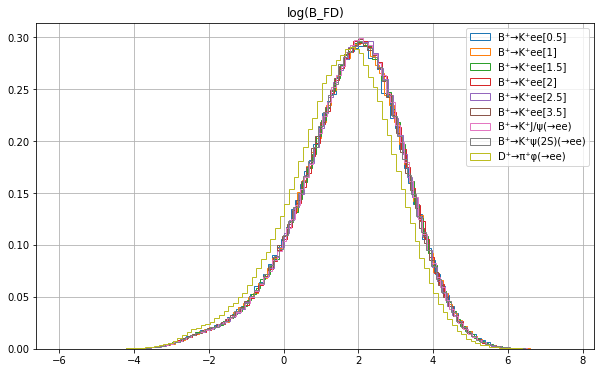

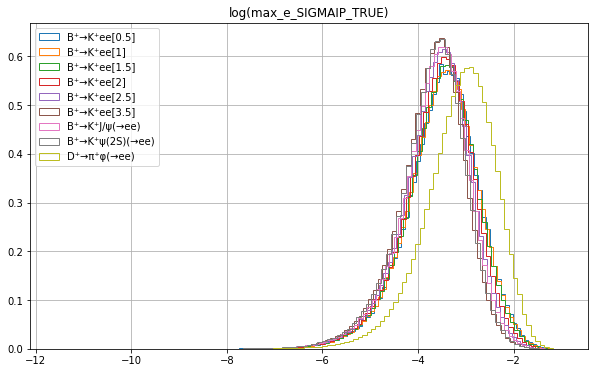

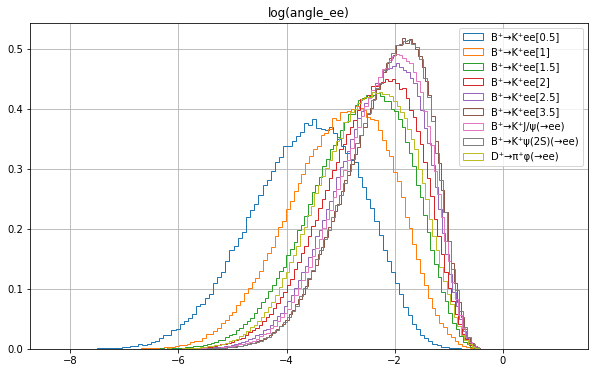

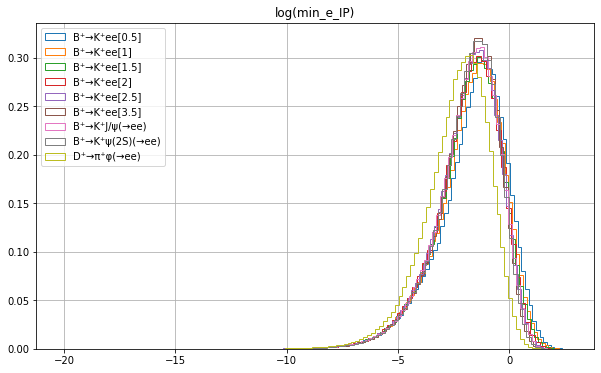

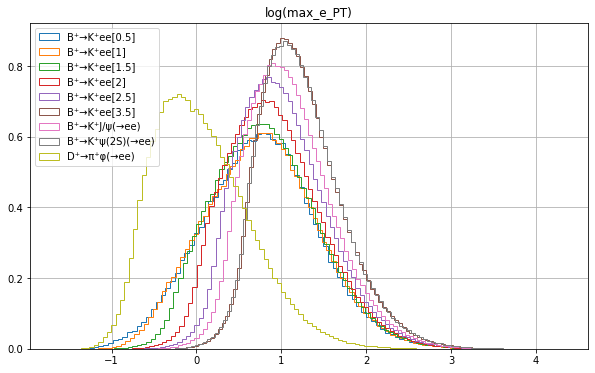

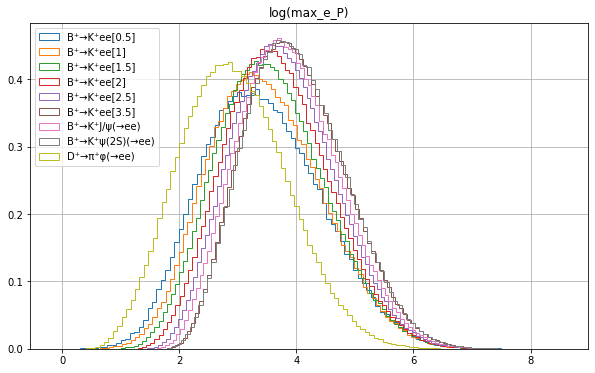

In [131]:
features_plots(train_ds_notrue)

### Preprocessing

In [132]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [133]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [157]:
feature_sets = [
    ("ptpt", ["log(ep_PT)", "log(em_PT)"]),
    ("mpta", ["log(angle_ee)", "log(max_e_PT)"]),
    ("mpa", ["log(angle_ee)", "log(max_e_P)"]),
]
    
train_datasets = [
    ("_full", train_ds_notrue),
]

test_datasets = [
    ("_full", test_ds_notrue),
]

all_datasets = list()
val_datasets = list()
for f in feature_sets:
    for t, v in zip(train_datasets, test_datasets):
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
        val_datasets.append(Dataset(f[1], v[1], aliases, "V%s[%s]"%(v[0],f[0])))

In [159]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [160]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [161]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [162]:
class Logger:
    def __init__(self, name=None):
        self.measurements = [{}]
        self.name = name
    def last(self):
        return self.measurements[-1]
    def log(self, **kwargs):
        self.measurements.append(kwargs)
    def update(self, **kwargs):
        self.last().update(kwargs)
    def extract(self, key, default=None, skip=True):
        index = list()
        result = list()
        for i, entry in enumerate(self.measurements):
            value = entry.get(key, default)
            if not (skip and value is None):
                index.append(i)
                result.append(value)
        return index, result

In [163]:
def model(inputs, outputs, hid=20):
    return nn.Sequential(
        nn.Linear(inputs, hid), nn.Softplus(),
        nn.Linear(hid, hid), nn.Softplus(),
        nn.Linear(hid, hid), nn.Softplus(),
        nn.Linear(hid, outputs),
    )

In [164]:
def validate(model, loader, wt):
    model.eval()

    total_loss = 0
    total_count = 0
    for batch in loader:
        x, y = batch
        pred = model(x)
        loss = F.cross_entropy(
            input=pred,
            target=y,
            weight=wt,
            reduction='sum',
        )
        total_loss += loss.item()
        total_count += x.shape[0]

    return total_loss / total_count    

In [165]:
def train(model, loader, epochs=20, weight=None, accumulate=False, logger=None, val_loader=None):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        model.train()

        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        if accumulate:
            opt.step()
            opt.zero_grad()

        train_loss = validate(model, loader, wt)
        val_loss = validate(model, val_loader, wt) if val_loader is not None else None
            
        if logger is None:
            logging.info("Epoch %d, train=%f val=%f", epoch, train_loss, val_loss)
        else:
            logger.log(train_loss=train_loss, val_loss=val_loss)
    model.eval()
    model.zero_grad(set_to_none=True)
    return model

### Weight limits estimation

In [166]:
def train_estimator(dataset, model, device=device, logger=None, val_dataset=None, batch_size=100000, batch_epochs=50, full_epochs=50):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    val_loader = None
    if val_dataset is not None:
        vds = torch.utils.data.TensorDataset(
            val_dataset.X(device=device, dtype=float),
            val_dataset.Y(device=device, dtype=torch.int64)
        )
        val_loader = Loader(vds, batch_size=batch_size, shuffle=False, device=device)
    loader = Loader(ds, batch_size=batch_size, shuffle=True, device=device)
    train(model, loader, epochs=batch_epochs, weight=dataset.weights, accumulate=False, logger=logger, val_loader=val_loader)
    loader = Loader(ds, batch_size=batch_size, shuffle=False, device=device)
    train(model, loader, epochs=full_epochs, weight=dataset.weights, accumulate=True, logger=logger, val_loader=val_loader)
    return model.eval()

In [167]:
def make_estimator(dataset, device=device, hid=20):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources), hid=hid)
    return torch.nn.Sequential(scaler, m).to(device)

In [168]:
%%time
all_est = list()
all_log = list()
for ds, vds in zip(all_datasets, val_datasets):
    logger = Logger(name="Est%s"%ds.name)
    est = make_estimator(ds, hid=20)
    train_estimator(ds, est, logger=logger, val_dataset=vds)
    all_est.append(est)
    all_log.append(logger)
    logging.info("Done %s, %s", logger.name, logger.last())

INFO:root:Done Est_full[ptpt], {'train_loss': 1.959477350827663, 'val_loss': 1.9592843950730727}
INFO:root:Done Est_full[mpta], {'train_loss': 1.8243781145560682, 'val_loss': 1.8246730900972588}
INFO:root:Done Est_full[mpa], {'train_loss': 1.430016180851889, 'val_loss': 1.4298722825912162}


CPU times: user 6min 46s, sys: 49.6 s, total: 7min 36s
Wall time: 7min 36s


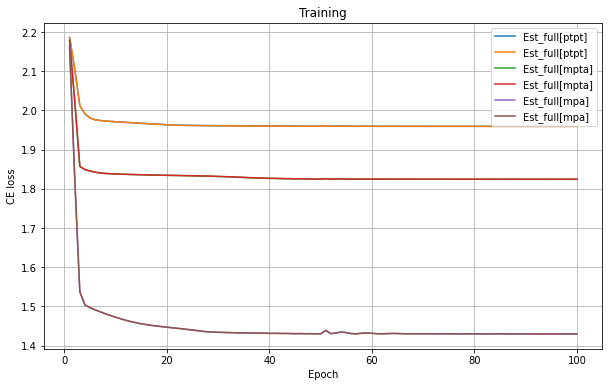

In [171]:
for logger in all_log:
    plt.plot(*logger.extract("train_loss"), label=logger.name)
    plt.plot(*logger.extract("val_loss"), label=logger.name)
plt.title("Training")
plt.ylabel("CE loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend()
plt.show()

In [172]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [173]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [174]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [175]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [176]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

In [211]:
def roc_check(tpr, fpr, limit):
    t_sort = torch.sort(tpr)[0]
    q = t_sort[int(len(t_sort)*(1-limit))].item()
    #print(q, torch.mean(fpr > q, dtype=float).item(), torch.mean(tpr > q, dtype=float).item())
    return torch.mean(fpr > q, dtype=float).item()

def roc_table(ds, est, limits=[0.97, 0.97, 0.95]):
    x = ds.X(device=device, dtype=float)
    y_pred = est(x)
    y_true = ds.Y(device=device, dtype=torch.int64)
    col_ix = np.arange(len(all_channel_names))[-3:]
    row_ix = np.arange(len(all_channel_names))[:-3]
    df = pd.DataFrame(index=all_channel_names[:-3], columns=["%s>%g"%(c, lim) for c, lim in zip(all_channel_names[-3:], limits)])
    df.columns.name = ds.name
    for cix, col, lim in zip(col_ix, df.columns, limits):
        for rix, row in zip(row_ix, df.index):
            pred = y_pred[:,cix]-y_pred[:,rix]
            tpr = pred[y_true==cix]
            fpr = pred[y_true==rix]
            #print(tpr.shape, fpr.shape)
            df.loc[row, col] = roc_check(tpr, fpr, lim)
    return df

In [212]:
roc_table(val_datasets[0], all_est[0])

V_full[ptpt] B⁺→K⁺J/ψ(→ee)>0.97 B⁺→K⁺ψ(2S)(→ee)>0.97 D⁺→π⁺φ(→ee)>0.95
B⁺→K⁺ee[0.5]           0.700367             0.595019         0.670166
B⁺→K⁺ee[1]             0.698141             0.599445         0.663766
B⁺→K⁺ee[1.5]           0.715443             0.610724         0.655346
B⁺→K⁺ee[2]              0.82755             0.666796         0.630596
B⁺→K⁺ee[2.5]           0.942296             0.821562         0.569667
B⁺→K⁺ee[3.5]           0.939455             0.969166         0.327234

In [213]:
roc_table(val_datasets[1], all_est[1])

V_full[mpta] B⁺→K⁺J/ψ(→ee)>0.97 B⁺→K⁺ψ(2S)(→ee)>0.97 D⁺→π⁺φ(→ee)>0.95
B⁺→K⁺ee[0.5]           0.378739             0.270266         0.606064
B⁺→K⁺ee[1]             0.592762             0.472362         0.685835
B⁺→K⁺ee[1.5]            0.73407             0.607769         0.614568
B⁺→K⁺ee[2]             0.849306             0.727824         0.498954
B⁺→K⁺ee[2.5]            0.93571             0.837541          0.37483
B⁺→K⁺ee[3.5]           0.940248             0.968747         0.170993

In [214]:
roc_table(val_datasets[2], all_est[2])

V_full[mpa]  B⁺→K⁺J/ψ(→ee)>0.97 B⁺→K⁺ψ(2S)(→ee)>0.97 D⁺→π⁺φ(→ee)>0.95
B⁺→K⁺ee[0.5]           0.002123             0.000239         0.298392
B⁺→K⁺ee[1]             0.076505             0.034814         0.838334
B⁺→K⁺ee[1.5]           0.296715              0.17741         0.647872
B⁺→K⁺ee[2]               0.5755             0.387488         0.371059
B⁺→K⁺ee[2.5]           0.833943              0.60831         0.112066
B⁺→K⁺ee[3.5]            0.94171             0.968047              0.0

### Weighting function

In [ ]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [ ]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [ ]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [ ]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [ ]:
def fix_linear(model, loader, n_outs, n_classes, selected_class):
    with torch.no_grad():
        W, counts = create_w(model[:3], loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, model[3], selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    logging.info("W=%s W+=%s L=%f coef=%s", W_np, W_pinv, L, to_numpy(model[3].weight.data))

In [ ]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None, logger=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W).astype(np.float64)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            t0 = (wcj>0)-0.02
            t1 = t0/wcj
            t1m = np.exp(np.min(t1)-t1)
            t1s = t1m/np.sum(t1m)
            wcj_ = -t0/(wcj**2)*t1s
            #wcj_ = ((wcj<0)*0.98 - (wcj>1)*0.02)*t1s             # f(wcj)
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            K = 1/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m)                        # W_m_

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0
            total_loss_c = 0
            total_loss_d = 0
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                
                loss_c = torch.sum(W*W_m_t)*K
                loss_d = -torch.sum(W*W_pinv_T)*K
                loss = loss_d + alpha * loss_c
                total_loss_c += loss_c.item()
                total_loss_d += loss_d.item()
                total_loss += loss.item()
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            if logger is None:
                print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
            else:
                logger.log(
                    total_loss=total_loss,
                    loss_c=total_loss_c,
                    loss_d=total_loss_d,
                    L=L,
                    det=det,
                    W=W_np,
                    W_pinv=W_pinv,
                )
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    fix_linear(model, loader, n_outs, n_classes, selected_class)
    return model

In [ ]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, logger=None, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=1, logger=logger)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=1000, alpha=300, logger=logger, **kwargs)
    #fix_linear(model, loader, n_outs, n_classes, selected_class)
    return model.eval()

In [ ]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, logger=None, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, logger=logger, **kwargs)
    
    def fix_linear(self, dataset, selected_class=0):
        loader = Loader(dataset, batch_size=100000, shuffle=False, device=device)
        fix_linear(self.model, loader, self.n_outs, self.n_classes, selected_class)

In [ ]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [ ]:
%%time
results = dict()
loggers = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        logger = Logger(name=name)
        w.train(ds, target_L=target_L, logger=logger)
        results[target_L, ds.name] = w
        loggers[target_L, ds.name] = logger
        logging.info("%s, %s", name, logger.last())

#### Learning curves

In [ ]:
def rk_from_w(W):
    Wf = W.astype(np.float64)
    Wp = np.linalg.pinv(Wf)
    res = make_weighting_lp(Wp)
    w = Wf.T@res
    return (1-w[1])/(1-w[0])

In [ ]:
for name, logger in loggers.items():
    if results[name].n_outs != 3:
        continue 
    xs, Ws = logger.extract("W")
    plt.plot(xs, [rk_from_w(W) for W in Ws], label=name[1])
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("RK")
plt.legend()
plt.grid()
plt.show()

In [ ]:
for name, logger in loggers.items():
    if results[name].n_outs != 4:
        continue 
    xs, Ws = logger.extract("W")
    plt.plot(xs, [rk_from_w(W) for W in Ws], label=name[1])
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("RK")
plt.legend()
plt.grid()
plt.show()

### Result analysis

In [ ]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [ ]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [ ]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [ ]:
w_train = make_w(train_ds_notrue, results.values(), "train, w")
w_train

In [ ]:
w_test = make_w(test_ds_notrue, results.values(), "test, w")
w_test

In [ ]:
make_R(1-w_train, "train, (R-1)*100")

In [ ]:
make_R(1-w_test, "test, (R-1)*100")

In [ ]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [ ]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [ ]:
map_all(compute_L, results, "L", dtype=float)

### L

In [ ]:
%%time
L_results = dict()
if False:
    for target_L in [0.03, 0.10, 1.0, None]:
        ds = all_datasets[0]
        est = all_est[0]
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        L_results[target_L] = w

In [ ]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [ ]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

### Conditional plots

In [ ]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected_notrue:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [ ]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

In [ ]:
plot_e_all("q2", results, np.linspace(0,14,101))

In [ ]:
plot_e_all("angle_ee", results, np.linspace(0,0.5,101))

### 

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for j, ds_i in enumerate([0,1,8,9]):
    ds = all_datasets[ds_i]
    ax_ = ax[j//2, j%2]
    w = results[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()

### Before and after training

In [ ]:
def set_weights(m, dataset, n_classes=None, selected_class=0, **kwargs):
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    if n_classes is None:
        n_classes = len(dataset.sources)
    model = m.model
    n_outs = m.n_outs
    scaler = model[0]
    base = model[:3]
    linear = model[3]
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

In [ ]:
results_initial = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w'%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        set_weights(w, ds)
        results_initial[target_L, ds.name] = w

In [ ]:
wi_train = make_w(train_ds_notrue, results_initial.values(), "train, w'")
wi_test = make_w(test_ds_notrue, results_initial.values(), "test, w'")

In [ ]:
wi_train

In [ ]:
wi_test

In [ ]:
make_R(1-w_test, "test, (R-1)*100")

In [ ]:
make_R(1-wi_test, "test, (R'-1)*100")

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for j, ds_i in enumerate([0,1,8,9]):
    ds = all_datasets[ds_i]
    ax_ = ax[j//2, j%2]
    w = results_initial[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()

### MSE

In [ ]:
def train_mse_(model, loader, target, epochs=20, weight=None, accumulate=False, logger=None, val_loader=None):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    t = from_numpy(target)
    for epoch in range(epochs):
        model.train()

        for batch in loader:
            x, y = batch
            pred = model(x).view(-1)
            loss = torch.sum(wt[y]*((pred-t[y])**2))
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        if accumulate:
            opt.step()
            opt.zero_grad()

        #train_loss = validate(model, loader, wt)
        #val_loss = validate(model, val_loader, wt) if val_loader is not None else None
            
        #if logger is None:
        #    logging.info("Epoch %d, train=%f val=%f", epoch, train_loss, val_loss)
        #else:
        #    logger.log(train_loss=train_loss, val_loss=val_loss)
    model.eval()
    model.zero_grad(set_to_none=True)
    return model

In [ ]:
def train_mse(dataset, model, target, device=device, logger=None, val_dataset=None, batch_size=100000, batch_epochs=50, full_epochs=50):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    val_loader = None
    if val_dataset is not None:
        vds = torch.utils.data.TensorDataset(
            val_dataset.X(device=device, dtype=float),
            val_dataset.Y(device=device, dtype=torch.int64)
        )
        val_loader = Loader(vds, batch_size=batch_size, shuffle=False, device=device)
    loader = Loader(ds, batch_size=batch_size, shuffle=True, device=device)
    train_mse_(model, loader, target, epochs=batch_epochs, weight=dataset.weights, accumulate=False, logger=logger, val_loader=val_loader)
    loader = Loader(ds, batch_size=batch_size, shuffle=False, device=device)
    train_mse_(model, loader, target, epochs=full_epochs, weight=dataset.weights, accumulate=True, logger=logger, val_loader=val_loader)
    return model.eval()

In [ ]:
def make_mse(dataset, device=device, hid=20):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources), hid=hid)
    return torch.nn.Sequential(
        scaler,
        m,
        nn.Softplus(),
        nn.Linear(len(dataset.sources), 1),
        nn.Sigmoid()
    ).to(device)

In [ ]:
class NamedModel:
    def __init__(self, name, model):
        self.name = name
        self.model = model

In [ ]:
%%time
mse_est = list()
mse_log = list()
for ds, vds in zip(all_datasets, val_datasets):
    name = "MSE%s"%ds.name
    logger = Logger(name=name)
    est = make_mse(ds, hid=20)
    obj = NamedModel(name, est)
    train_mse(ds, est, [0.10, 0.02, 0.02, 0.02], logger=logger, val_dataset=vds, batch_epochs=200)
    mse_est.append(obj)
    mse_log.append(logger)
    logging.info("Done %s, %s", logger.name, logger.last())

In [ ]:
mse_train = make_w(train_ds_notrue, mse_est, "train, mse")
mse_test = make_w(test_ds_notrue, mse_est, "test, mse")

In [ ]:
mse_test

In [ ]:
make_R(1-mse_test, "test, (R-1)*100")